# Predicting Breast Cancer Survival Time: Random Survival Forest Model

Dataset: Supplementary Data 3 in the following link: https://www.nature.com/articles/s41523-021-00319-4#MOESM5 

### Import Necessary Libraries

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

%matplotlib inline

### Load Data

In [110]:
df = pd.read_csv("breast_cancer_data_ML.csv")

### Step 1: Preprocessing Data

#### Select Relevant Features for Model

In [111]:
features = df [['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'subtype', 'metastatic site']]
target = df[['Status OS', 'OS at baseline']] 

# [[selects multiple columns]], result is a dataframe.
# [selects a single column], result is a series.

#### Feature Engineering: Tumor Grade

In [92]:
# converting tumor 1 or 2 to 1.5 to average between 2 guesses.
df["Tumor grade"] = df["Tumor grade"].replace('1 or 2',1.5)

df["Tumor grade"] = pd.to_numeric(df["Tumor grade"])

In [93]:
df['Tumor grade'].head(10)

0    3.0
1    1.5
2    3.0
3    1.5
4    3.0
5    3.0
6    1.5
7    NaN
8    1.5
9    3.0
Name: Tumor grade, dtype: float64

In [94]:
# Create an imputer to fill missing values with 0.1
imputer = SimpleImputer(strategy='constant', fill_value=0.1)

# Apply the imputer to the "Tumor grade" column
df['Tumor grade'] = imputer.fit_transform(df[['Tumor grade']])

In [95]:
df['Tumor grade'].head(10)

0    3.0
1    1.5
2    3.0
3    1.5
4    3.0
5    3.0
6    1.5
7    0.1
8    1.5
9    3.0
Name: Tumor grade, dtype: float64

In [107]:
# Convert the column to int64
# df['Tumor grade'] = df['Tumor grade'].astype('int64')

# Convert 'Tumor grade' to int64
df['Tumor grade'] = df['Tumor grade'].astype('int64')

In [108]:
df['Tumor grade'].head(50)

0     3
1     1
2     3
3     1
4     3
5     3
6     1
7     0
8     1
9     3
10    1
11    1
12    3
13    3
14    1
15    0
16    1
17    3
18    3
19    1
20    3
22    1
23    1
24    3
25    1
26    1
27    3
28    1
29    1
30    3
31    1
32    1
33    1
34    1
35    1
36    1
37    0
38    3
39    3
40    1
41    3
42    1
43    1
44    3
45    3
46    1
47    3
48    0
49    1
50    3
Name: Tumor grade, dtype: int64

#### Define Preprocesssing for Numeric and Categorical Variables

In [112]:
# List of numeric features which will be included in model
numeric_features = ['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline']

# List of categorical features which will be included in model
categorical_features = ['subtype', 'metastatic site'] # subtype has no missing values, metastatic site has 1

#### Numeric Pipeline:

In [113]:
# Creates pipeline for preprocessing numeric features. Scaling. Previously had imputing, but not needed anymore.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) # Scale numeric features

# Pipeline from sklearn.pipeline allows chaining of multiple preprocessing steps together.
# Standardizing the features involves subtracting the mean and scaling to unit variance.
# ML algorithms perform better when input data is standardized.

#### Categorical Pipeline:

1 missing value in 'metastatic site' is removed below

In [114]:
# Drop rows with missing values in categorical features
df = df.dropna(subset=categorical_features)

In [115]:
# Creates pipeline for preprocessing categorical features
categorical_transformer = OneHotEncoder()  # One-hot encode categorical features

# One-hot encoding converts categorical variables into format for ML algorithms.
# Creates binary columns for each category so model can interpret categorical data

#### Combine Numeric and Categorical Transformers into Single Preprocessor

ColumnTransformer takes list of tuples where each tuple contains:

- Name for transformer.
- The transformer itself (can be a pipeline)
- List of columns which transformer is applied to (original features)

In [116]:
# Combining transformers into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # applies numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features)]) # applies cat transformer to cat features

#### Converting to Array Suitable for Survival Analysis

In [117]:
# Creating the survival dataset directly
# Converts 'target' with columns 'Status OS' and 'OS at baseline' into structured array suitable for survival analysis
y = Surv.from_dataframe("Status OS", "OS at baseline", target)

### Step 2: Model Fitting: Random Survival Forest

Using RandomSurvivalForest from sksurv.ensemble module

In [137]:
# Define the model
model = RandomSurvivalForest(
    n_estimators=200, # No. of trees in random forest
    random_state=40 # Random seed for reproducibility
)

#### Creating Second Pipeline: Preprocessing and Model

Rationale: Streamlines workflow

In [138]:
# Create a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # Applies preprocessor (numeric and categorical transformers)
    ('model', model)]) # Fitting RSF model on preprocessed data

### Step 3: Model Training and Testing

#### Splitting Data into Training and Testing Sets

In [139]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=40)

#### Training Model

In [140]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'PS',
                                                   'CTCs counts at baseline',
                                                   'MAF of gene used at '
                                                   'baseline']),
                                                 ('cat', OneHotEncoder(),
                                                  ['subtype',
                                                   'metastatic site'])])),
                ('model',
                 RandomSurvivalForest(n_estimators=200, random_state=40))])

In [141]:
# Predict on the test set
y_pred = pipeline.predict(X_test) # Using trained pipeline to predict on test set

### Step 4: Model Evaluation

In [142]:
# Evaluate the model on the test set using concordance index
c_index = concordance_index_censored(y_test['Status OS'], y_test['OS at baseline'], y_pred)[0]
print(f'Test set concordance index score: {c_index}')

# concordance_index_censored function requires event indicator (Status OS), surival times (OS at baseline),
# and predicted survival times.

Test set concordance index score: 0.7482876712328768


# RSF Model Accuracy Score: 74.82%

---

# Comparison Between Other Statistical Models

### Cox Proportional Hazard Model

In [143]:
from lifelines import CoxPHFitter

<lifelines.CoxPHFitter: fitted with 197 total observations, 55 right-censored observations>
             duration col = 'OS at baseline'
                event col = 'Status OS'
      baseline estimation = breslow
   number of observations = 197
number of events observed = 142
   partial log-likelihood = -628.14
         time fit was run = 2024-07-21 15:03:33 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
AGE                           -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
PS                             0.09       1.09       0.17            -0.25             0.42                 0.78                 1.53
CTCs counts at baseline        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MAF of gene used at baseline   0.03       1.03       0.01             0.02             0.04                 1.02                 1.04
subtype_Triple negative        1.04       2.84       0.20             0.65             1.44                 1.91                 4.21
metastatic site_Visceral       0.36       1.44       0.22            -0.07             0.79                 0.93                 2.21

                               cmp to     z      p   -log2(p)
covariate                                                    
AGE                              0.00 -0.83   0.41       1.30
PS                               0.00  0.50   0.62       0.70
CTCs counts at baseline          0.00  0.59   0.55       0.85
MAF of gene used at baseline     0.00  6.33 <0.005      31.96
subtype_Triple negative          0.00  5.20 <0.005      22.23
metastatic site_Visceral         0.00  1.65   0.10       3.35
---
Concordance = 0.70
Partial AIC = 1268.28
log-likelihood ratio test = 71.00 on 6 df
-log2(p) of ll-ratio test = 41.84

<Axes: xlabel='log(HR) (95% CI)'>

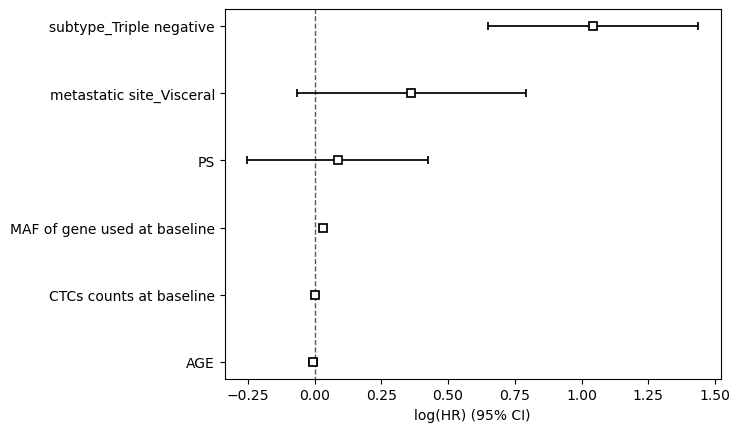

In [144]:
# Select features and target
features = df[['AGE', 'PS', 'CTCs counts at baseline', 'MAF of gene used at baseline', 'subtype', 'metastatic site']]
target = df[['Status OS', 'OS at baseline']]

# Combine features and target into one DataFrame for fitting the model
data = pd.concat([features, target], axis=1)

# Encode categorical variables
# Note: Ensure that 'subtype' and 'metastatic site' are categorical in your data. 
# You may need to convert them to category type if they are not.
data['subtype'] = data['subtype'].astype('category')
data['metastatic site'] = data['metastatic site'].astype('category')

# Use pd.get_dummies to one-hot encode categorical variables
data = pd.get_dummies(data, columns=['subtype', 'metastatic site'], drop_first=True)

# Initialize CoxPHFitter
cph = CoxPHFitter()

# Fit the model
cph.fit(data, duration_col='OS at baseline', event_col='Status OS')

# Print summary of the model
cph.print_summary()

# Plot the survival function for a set of covariates
cph.plot()

# Cox PH Model Accuracy Score: 70%